# 1. Annotate Merged Raw Data with CellTypist

This script loads the merged and processed dataset (`merged_raw_processed.h5ad`),
annotates cell types using CellTypist models (Mouse Isocortex/Hippocampus and Dentate Gyrus),
and saves the annotated data along with visualizations and summaries.

In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
import warnings
from celltypist import models, annotate
import seaborn as sns
import random
import importlib

In [2]:
# --- Configuration ---

# Check if running in Jupyter notebook
try:
    from IPython import get_ipython # type: ignore
    IN_NOTEBOOK = get_ipython() is not None
except ImportError:
    IN_NOTEBOOK = False

# Set seeds for reproducibility
random_seed = 0
np.random.seed(random_seed)
random.seed(random_seed)
sc.settings.seed = random_seed # type: ignore

# REMOVE_DOUBLETS = True
REMOVE_DOUBLETS = False

# Define Project Directories
PROJECT_DIR = "D:/Github/SRF_Linda_RNA"
WORKING_DIR = os.path.join(PROJECT_DIR, "combine_data")
os.chdir(WORKING_DIR)
sys.path.insert(0, WORKING_DIR)

# Force reload the functions module to ensure we have the latest version
if 'functions' in sys.modules:
    importlib.reload(sys.modules['functions'])
from functions import *  # noqa: E402 F403

In [3]:
# Define models and their descriptions (same as before)
MODELS = {
    "Mouse_Isocortex_Hippocampus": {
        "description": "Cell types from the adult mouse isocortex (neocortex) and hippocampal formation",
        "cell_types": 42,
        "version": "v1",
        "reference": "https://doi.org/10.1016/j.cell.2021.04.021"
    },
    "Mouse_Dentate_Gyrus": {
        "description": "Cell types from the dentate gyrus in perinatal, juvenile, and adult mice",
        "cell_types": 24,
        "version": "v1",
        "reference": "https://doi.org/10.1038/s41593-017-0056-2"
    }
}

# Set up directories based on the output of the previous script
if REMOVE_DOUBLETS:
    BASE_RESULTS_DIR = os.path.join(WORKING_DIR, "results_from_raw", "doublets_removed")
else:
    BASE_RESULTS_DIR = os.path.join(WORKING_DIR, "results_from_raw")
OUTPUT_DIR = BASE_RESULTS_DIR

INPUT_H5AD_FILE = os.path.join(BASE_RESULTS_DIR, 'merged_raw_processed.h5ad')
MODEL_DIR = os.path.join(WORKING_DIR, "models")

# Define output file name for the annotated data
OUTPUT_H5AD_FILE = os.path.join(OUTPUT_DIR, "annotated.h5ad")

# CellTypist parameters
MAJORITY_VOTING = True
PROB_THRESHOLD = 0.5

LEIDEN_KEY = 'leiden_0.4'

## Load Merged Data

In [4]:
print("Loading merged dataset...")
if not os.path.exists(INPUT_H5AD_FILE):
    raise FileNotFoundError(f"Input file not found: {INPUT_H5AD_FILE}. Please run script '0_merge_raw_and_process.py' first.")

adata = sc.read_h5ad(INPUT_H5AD_FILE)
print(f"Loaded {adata.n_obs} cells and {adata.n_vars} genes from {INPUT_H5AD_FILE}")

Loading merged dataset...
Loaded 28026 cells and 26881 genes from D:/Github/SRF_Linda_RNA\combine_data\results_from_raw\merged_raw_processed.h5ad


In [5]:
print(adata.layers)

Layers with keys: 


In [6]:
# Basic check for expected structure
if 'X_umap' not in adata.obsm:
    warnings.warn("UMAP coordinates ('X_umap') not found. Plots might fail.")
if LEIDEN_KEY not in adata.obs:
    warnings.warn(f"Leiden clustering key '{LEIDEN_KEY}' not found. Comparison plots might fail.")

## Prepare Data for CellTypist

In [7]:
# Create a copy for CellTypist analysis to avoid modifying the original loaded data
adata_ct = adata.copy()

print("Preparing data for CellTypist analysis...")

# CellTypist expects log1p normalized data with a target sum (e.g., 10,000).
# We need to prepare this from the raw counts stored in adata_ct.raw.

if adata_ct.raw is None:
    raise ValueError("AnnData object does not contain raw counts in .raw. Cannot prepare data for CellTypist.")

# 1. Use raw counts for the *current* genes in adata_ct.var_names
print("Using raw counts from .raw slot for currently filtered genes.")
# Index the raw object by the variable names of the current object
adata_ct.X = adata_ct.raw[:, adata_ct.var_names].X.copy() # type: ignore

# 2. Normalize total counts per cell to 10,000
print("Normalizing total counts to 10,000 per cell...")
sc.pp.normalize_total(adata_ct, target_sum=10000)

# 3. Log1p transform the data
print("Applying log1p transformation...")
sc.pp.log1p(adata_ct)

# Verification step
print("Verifying data format for CellTypist...")
# Check if max value is reasonable for log1p data
if adata_ct.X.max() > 20: # type: ignore
     warnings.warn(f"Maximum value in .X ({adata_ct.X.max():.2f}) seems high for log1p data.") # type: ignore
# Check sum (should be close to log1p(10000) ~ 9.21 per cell on average, but varies)
# mean_log1p_sum = np.mean(adata_ct.X.sum(axis=1))
# print(f"Mean sum of log1p values per cell: {mean_log1p_sum:.2f}") # This check is less reliable

print("Data preparation for CellTypist complete.")

Preparing data for CellTypist analysis...
Using raw counts from .raw slot for currently filtered genes.
Normalizing total counts to 10,000 per cell...
Applying log1p transformation...
Verifying data format for CellTypist...
Data preparation for CellTypist complete.


## Run CellTypist Annotation

🔬 Input data has 28026 cells and 26881 genes
🔗 Matching reference genes in the model



Running CellTypist annotation with majority_voting=True, prob_threshold=0.5

Processing model: Mouse_Isocortex_Hippocampus
Description: Cell types from the adult mouse isocortex (neocortex) and hippocampal formation
Loading model from D:/Github/SRF_Linda_RNA\combine_data\models\Mouse_Isocortex_Hippocampus.pkl
Running CellTypist annotation...


🧬 3277 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 15
🗳️ Majority voting the predictions
✅ Majority voting done!


Added CellTypist predictions with prefix 'ISO_' to adata.obs
Generating plots...


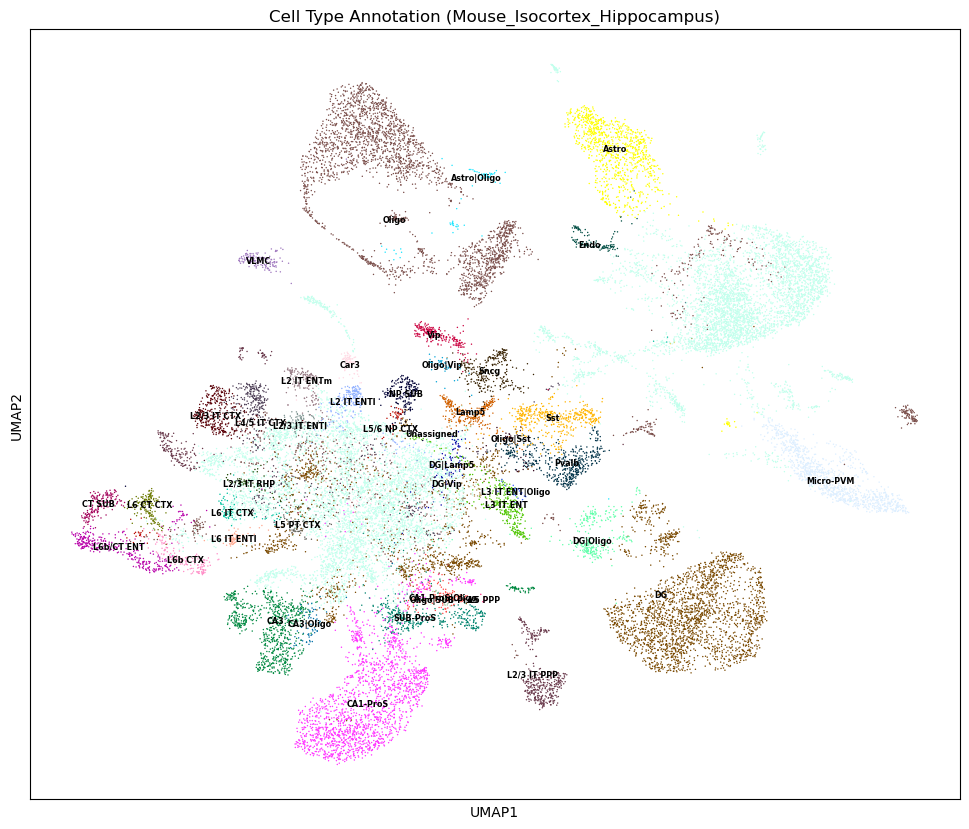

Generated UMAP plot for Mouse_Isocortex_Hippocampus cell types.


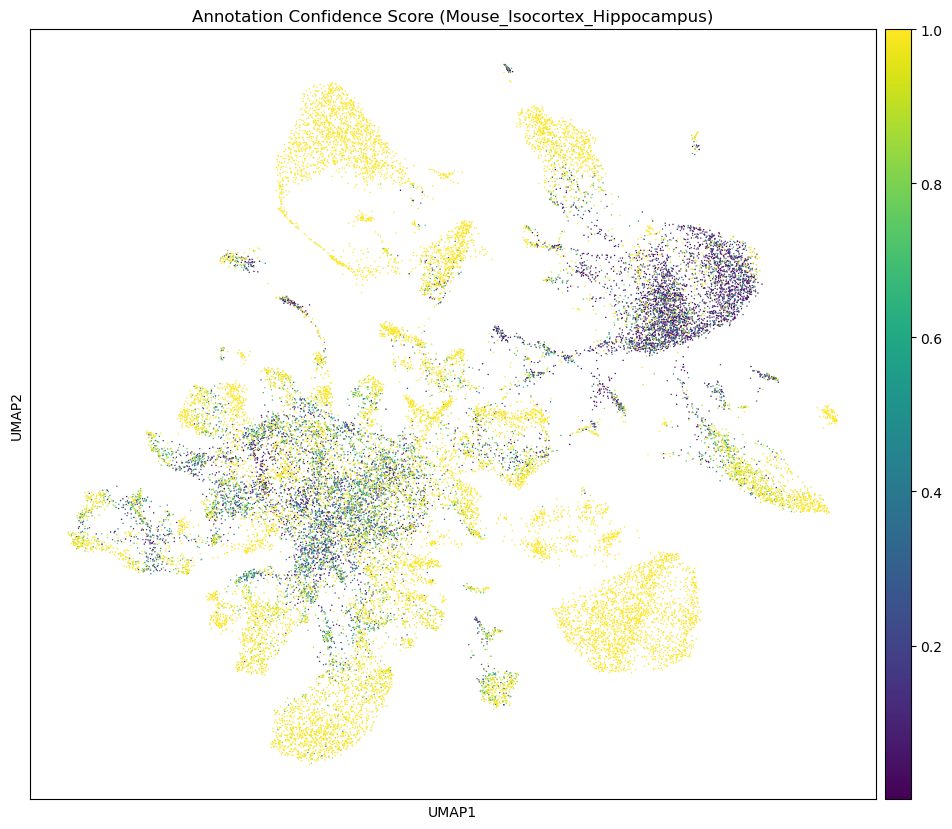

🔬 Input data has 28026 cells and 26881 genes
🔗 Matching reference genes in the model


Generated UMAP plot for Mouse_Isocortex_Hippocampus confidence scores.
Saved cell type summary to D:/Github/SRF_Linda_RNA\combine_data\results_from_raw\merged_raw_Mouse_Isocortex_Hippocampus_cell_type_summary.csv

Processing model: Mouse_Dentate_Gyrus
Description: Cell types from the dentate gyrus in perinatal, juvenile, and adult mice
Loading model from D:/Github/SRF_Linda_RNA\combine_data\models\Mouse_Dentate_Gyrus.pkl
Running CellTypist annotation...


🧬 3898 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 15
🗳️ Majority voting the predictions
✅ Majority voting done!


Added CellTypist predictions with prefix 'DG_' to adata.obs
Generating plots...


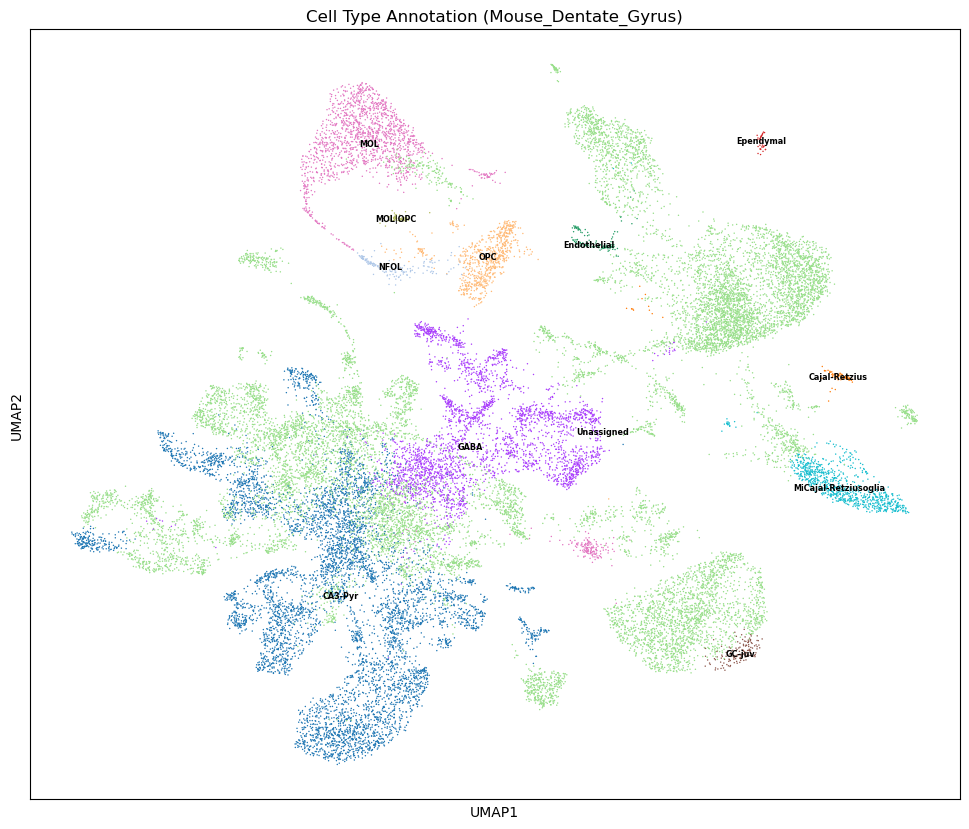

Generated UMAP plot for Mouse_Dentate_Gyrus cell types.


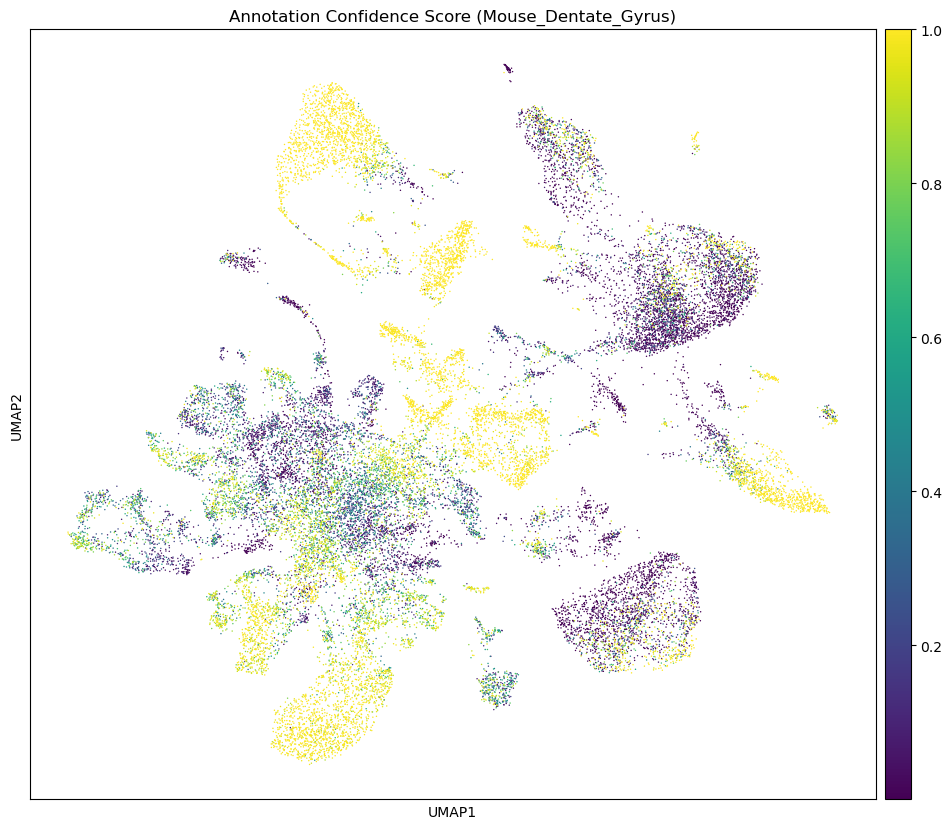

Generated UMAP plot for Mouse_Dentate_Gyrus confidence scores.
Saved cell type summary to D:/Github/SRF_Linda_RNA\combine_data\results_from_raw\merged_raw_Mouse_Dentate_Gyrus_cell_type_summary.csv


In [8]:
print(f"\nRunning CellTypist annotation with majority_voting={MAJORITY_VOTING}, prob_threshold={PROB_THRESHOLD}")

for model_name, model_info in MODELS.items():
    print(f"\nProcessing model: {model_name}")
    print(f"Description: {model_info['description']}")

    model_path = os.path.join(MODEL_DIR, f"{model_name}.pkl")
    if not os.path.exists(model_path):
        print(f"Model file not found at {model_path}. Attempting to download...")
        try:
            # Ensure the models module is updated to find the model online
            models.celltypist_models(force_update = False) # type: ignore
            model = models.Model.load(model_name) # Try loading by name (downloads if found)
            model.write(model_path) # Save downloaded model
            print(f"Model downloaded and saved to {model_path}")
        except Exception as e:
            raise FileNotFoundError(f"Model file not found at {model_path} and download failed: {e}")
    else:
        print(f"Loading model from {model_path}")
        # model = models.Model.load(model_path) # No need to load again if just checking existence

    # Run annotation
    print("Running CellTypist annotation...")
    try:
        predictions = annotate(
            adata_ct,
            model=model_path,
            majority_voting=MAJORITY_VOTING,
            mode='prob match',
            p_thres=PROB_THRESHOLD
        )

        # Add annotations with model-specific prefix
        prefix = 'ISO_' if 'Isocortex' in model_name else 'DG_'
        # Use the standard to_adata method to add results
        # This adds 'majority_voting', 'conf_score', and potentially others with the prefix
        predictions.to_adata(adata_ct, prefix=prefix) # type: ignore
        # Optionally add probability matrix (can make file large)
        # predictions.to_adata(adata_ct, insert_prob=True, prefix=f'{prefix}prob_')
        print(f"Added CellTypist predictions with prefix '{prefix}' to adata.obs")

    except Exception as e:
        print(f"ERROR running CellTypist for model {model_name}: {e}")
        continue # Skip to the next model if one fails

    # Generate plots
    print("Generating plots...")
    plot_subdir = os.path.join(OUTPUT_DIR, "plots")
    os.makedirs(plot_subdir, exist_ok=True)
    sc.settings.figdir = plot_subdir # Set scanpy figure directory

    # Cell type annotation plot
    if f'{prefix}majority_voting' in adata_ct.obs.columns and 'X_umap' in adata_ct.obsm:
        fig, ax = plt.subplots(figsize=(12, 10))
        sc.pl.umap(adata_ct, color=f'{prefix}majority_voting', ax=ax,
                  legend_loc='on data', # Use 'on data' for potentially many categories
                  legend_fontsize='xx-small', # Adjust font size if needed
                  title=f"Cell Type Annotation ({model_name})", show=True) # Show plots
        # plt.tight_layout() # scanpy save handles layout
        # plt.close(fig) # Close figure after saving
        print(f"Generated UMAP plot for {model_name} cell types.")
    else:
         print(f"Skipping cell type plot for {model_name} (missing UMAP or annotation column).")

    # Confidence score plot
    if f'{prefix}conf_score' in adata_ct.obs.columns and 'X_umap' in adata_ct.obsm:
        fig, ax = plt.subplots(figsize=(12, 10))
        sc.pl.umap(adata_ct, color=f'{prefix}conf_score', ax=ax,
                  title=f"Annotation Confidence Score ({model_name})", cmap='viridis', show=True) # Show plots
        # plt.tight_layout()
        # plt.close(fig)
        print(f"Generated UMAP plot for {model_name} confidence scores.")
    else:
        print(f"Skipping confidence score plot for {model_name} (missing UMAP or confidence column).")

    # Generate summary statistics
    if f'{prefix}majority_voting' in adata_ct.obs.columns:
        cell_type_counts = adata_ct.obs[f'{prefix}majority_voting'].value_counts()
        cell_type_df = pd.DataFrame({
            'cell_type': cell_type_counts.index,
            'cell_count': cell_type_counts.values,
            'percentage': (cell_type_counts.values / cell_type_counts.sum() * 100).round(2) # type: ignore
        })
        cell_type_df = cell_type_df.sort_values('cell_count', ascending=False).reset_index(drop=True)

        # Save summary to CSV
        summary_file = os.path.join(OUTPUT_DIR, f"merged_raw_{model_name}_cell_type_summary.csv")
        cell_type_df.to_csv(summary_file, index=False)
        print(f"Saved cell type summary to {summary_file}")
    else:
        print(f"Skipping summary generation for {model_name} (missing annotation column).")

## Save Annotated Data

In [9]:
print(f"\nSaving annotated data to {OUTPUT_H5AD_FILE}")
try:
    # Ensure the output directory exists before writing
    os.makedirs(os.path.dirname(OUTPUT_H5AD_FILE), exist_ok=True)
    adata_ct.write(OUTPUT_H5AD_FILE) # type: ignore
    print("Successfully saved annotated AnnData object.")
except Exception as e:
    print(f"Error saving annotated AnnData object: {e}")


Saving annotated data to D:/Github/SRF_Linda_RNA\combine_data\results_from_raw\annotated.h5ad
Successfully saved annotated AnnData object.


## Final Summary and Comparisons

In [10]:
print(f"\n{'='*50}")
print("CELLTYPIST ANALYSIS COMPLETED")
print(f"{'='*50}")
print(f"Input file: {INPUT_H5AD_FILE}")
print(f"Number of cells: {adata_ct.n_obs}")
print(f"Number of genes: {adata_ct.n_vars}")
print(f"Models processed: {', '.join(MODELS.keys())}")
print(f"Annotated data saved to: {os.path.abspath(OUTPUT_H5AD_FILE)}")
print(f"Plots and summaries saved to: {os.path.abspath(OUTPUT_DIR)}")
print(f"{'='*50}")


CELLTYPIST ANALYSIS COMPLETED
Input file: D:/Github/SRF_Linda_RNA\combine_data\results_from_raw\merged_raw_processed.h5ad
Number of cells: 28026
Number of genes: 26881
Models processed: Mouse_Isocortex_Hippocampus, Mouse_Dentate_Gyrus
Annotated data saved to: D:\Github\SRF_Linda_RNA\combine_data\results_from_raw\annotated.h5ad
Plots and summaries saved to: D:\Github\SRF_Linda_RNA\combine_data\results_from_raw



Comparing annotations between models (Dentate Gyrus vs Isocortex/Hippocampus)...
Saved model comparison table to D:/Github/SRF_Linda_RNA\combine_data\results_from_raw\model_comparison_raw.csv


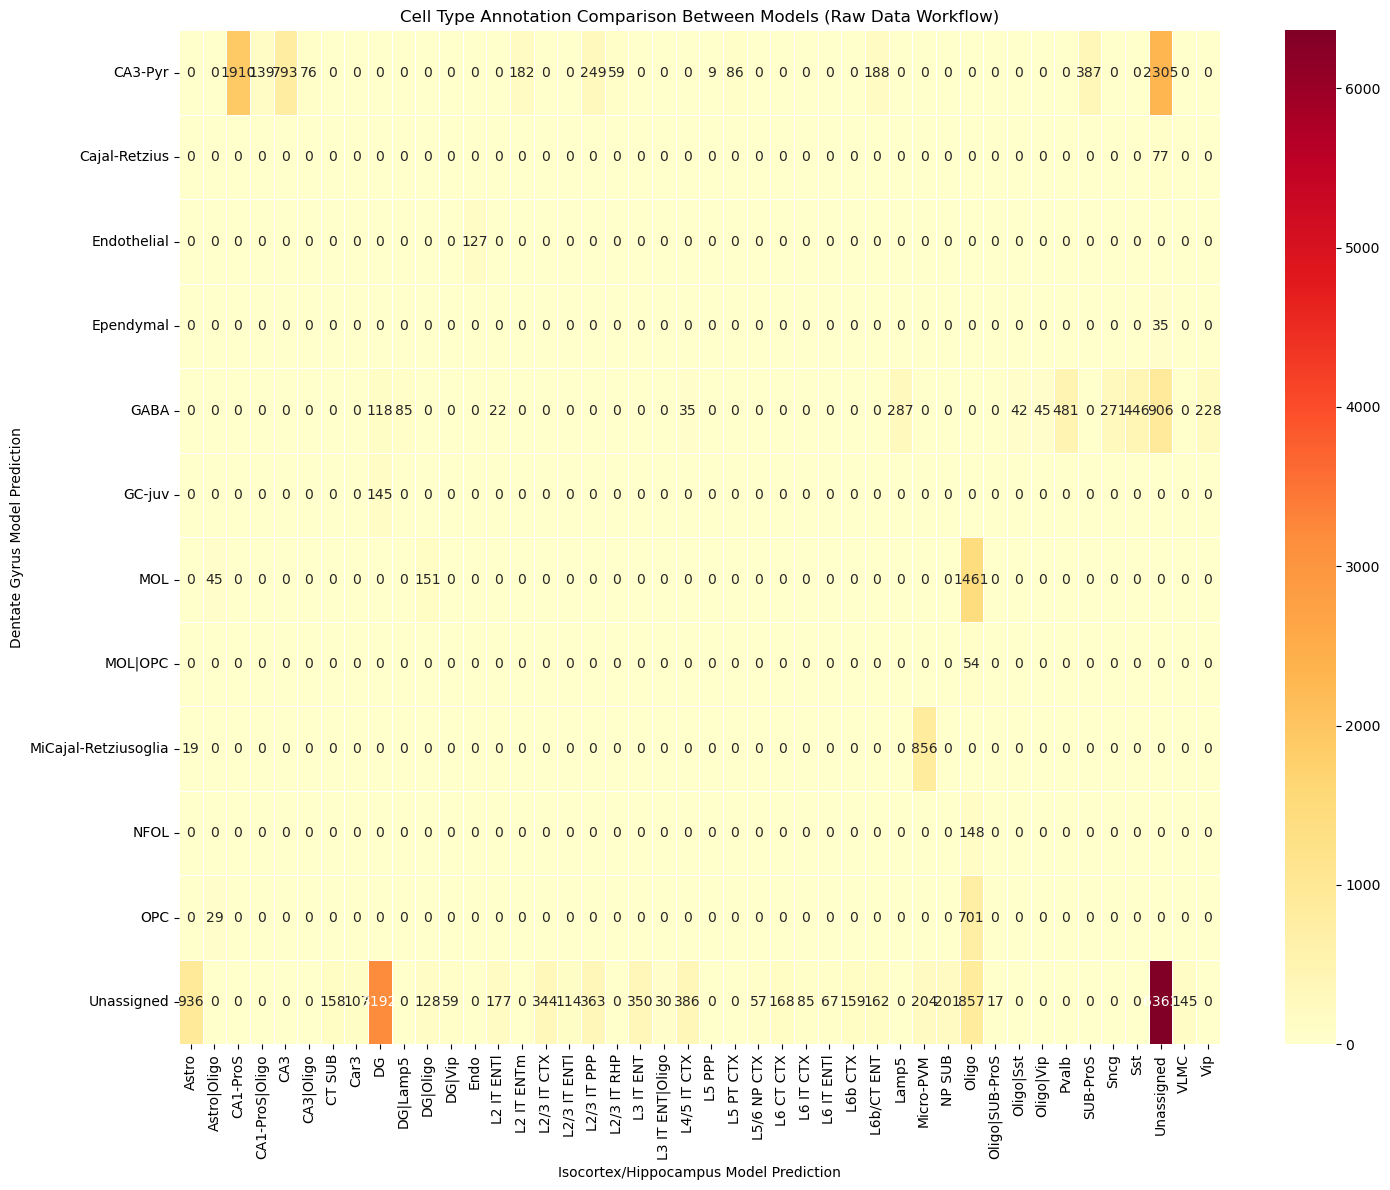

Generated model comparison heatmap


In [11]:
# Additional analysis: Compare annotations between models
dg_col = 'DG_majority_voting'
iso_col = 'ISO_majority_voting'
if dg_col in adata_ct.obs.columns and iso_col in adata_ct.obs.columns:
    print("\nComparing annotations between models (Dentate Gyrus vs Isocortex/Hippocampus)...")

    # Create contingency table
    annotation_comparison = pd.crosstab(
        adata_ct.obs[dg_col],
        adata_ct.obs[iso_col]
    )

    # Save comparison table
    comparison_file = os.path.join(OUTPUT_DIR, "model_comparison_raw.csv")
    annotation_comparison.to_csv(comparison_file)
    print(f"Saved model comparison table to {comparison_file}")

    # Plot comparison heatmap
    try:
        plt.figure(figsize=(15, 12))
        sns.heatmap(annotation_comparison, cmap='YlOrRd', annot=True, fmt='g', linewidths=.5)
        plt.title('Cell Type Annotation Comparison Between Models (Raw Data Workflow)')
        plt.xlabel('Isocortex/Hippocampus Model Prediction')
        plt.ylabel('Dentate Gyrus Model Prediction')
        plt.tight_layout()
        # heatmap_file = os.path.join(OUTPUT_DIR, "plots", "model_comparison_heatmap_raw.png")
        # plt.savefig(heatmap_file, dpi=150)
        # plt.close()
        plt.show()
        print("Generated model comparison heatmap")
    except Exception as e:
        print(f"Could not generate comparison heatmap: {e}")

else:
    print("\nSkipping model comparison (missing annotations from both models).")


Comparing CellTypist annotations with Leiden clusters ('leiden_0.4')...

--- Comparison for Mouse_Isocortex_Hippocampus vs leiden_0.4 --- 


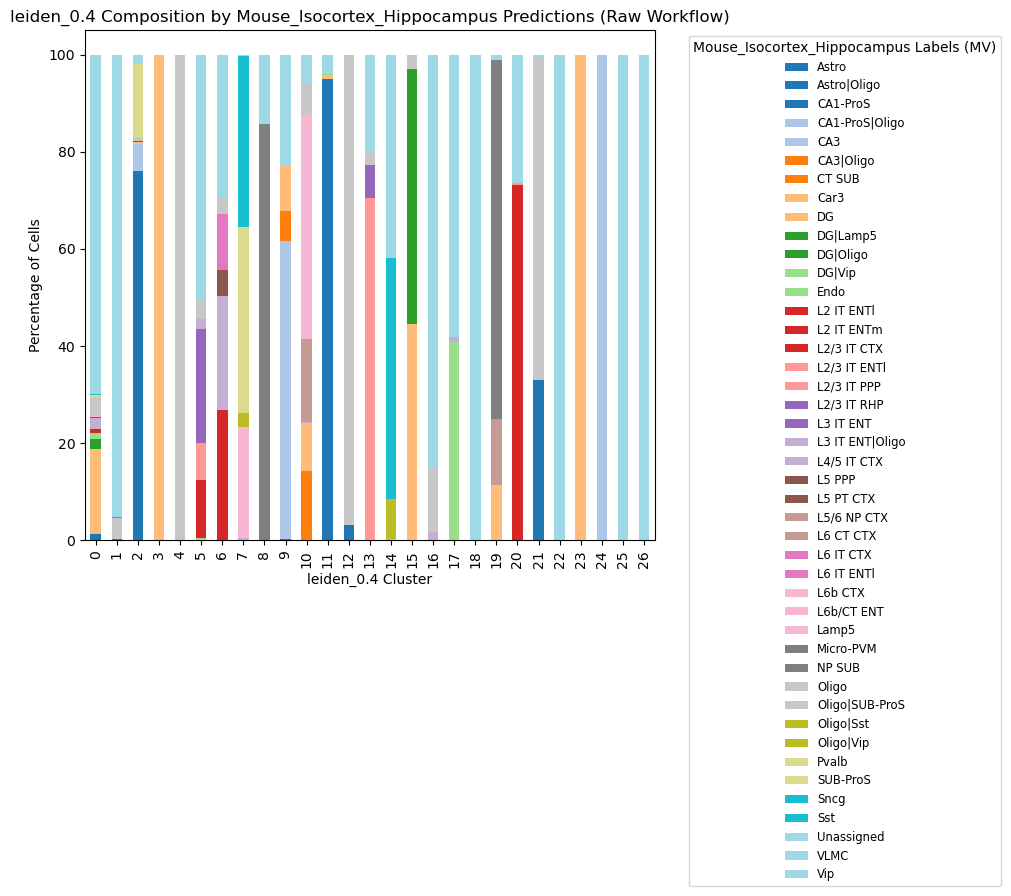

Generated stacked bar plot


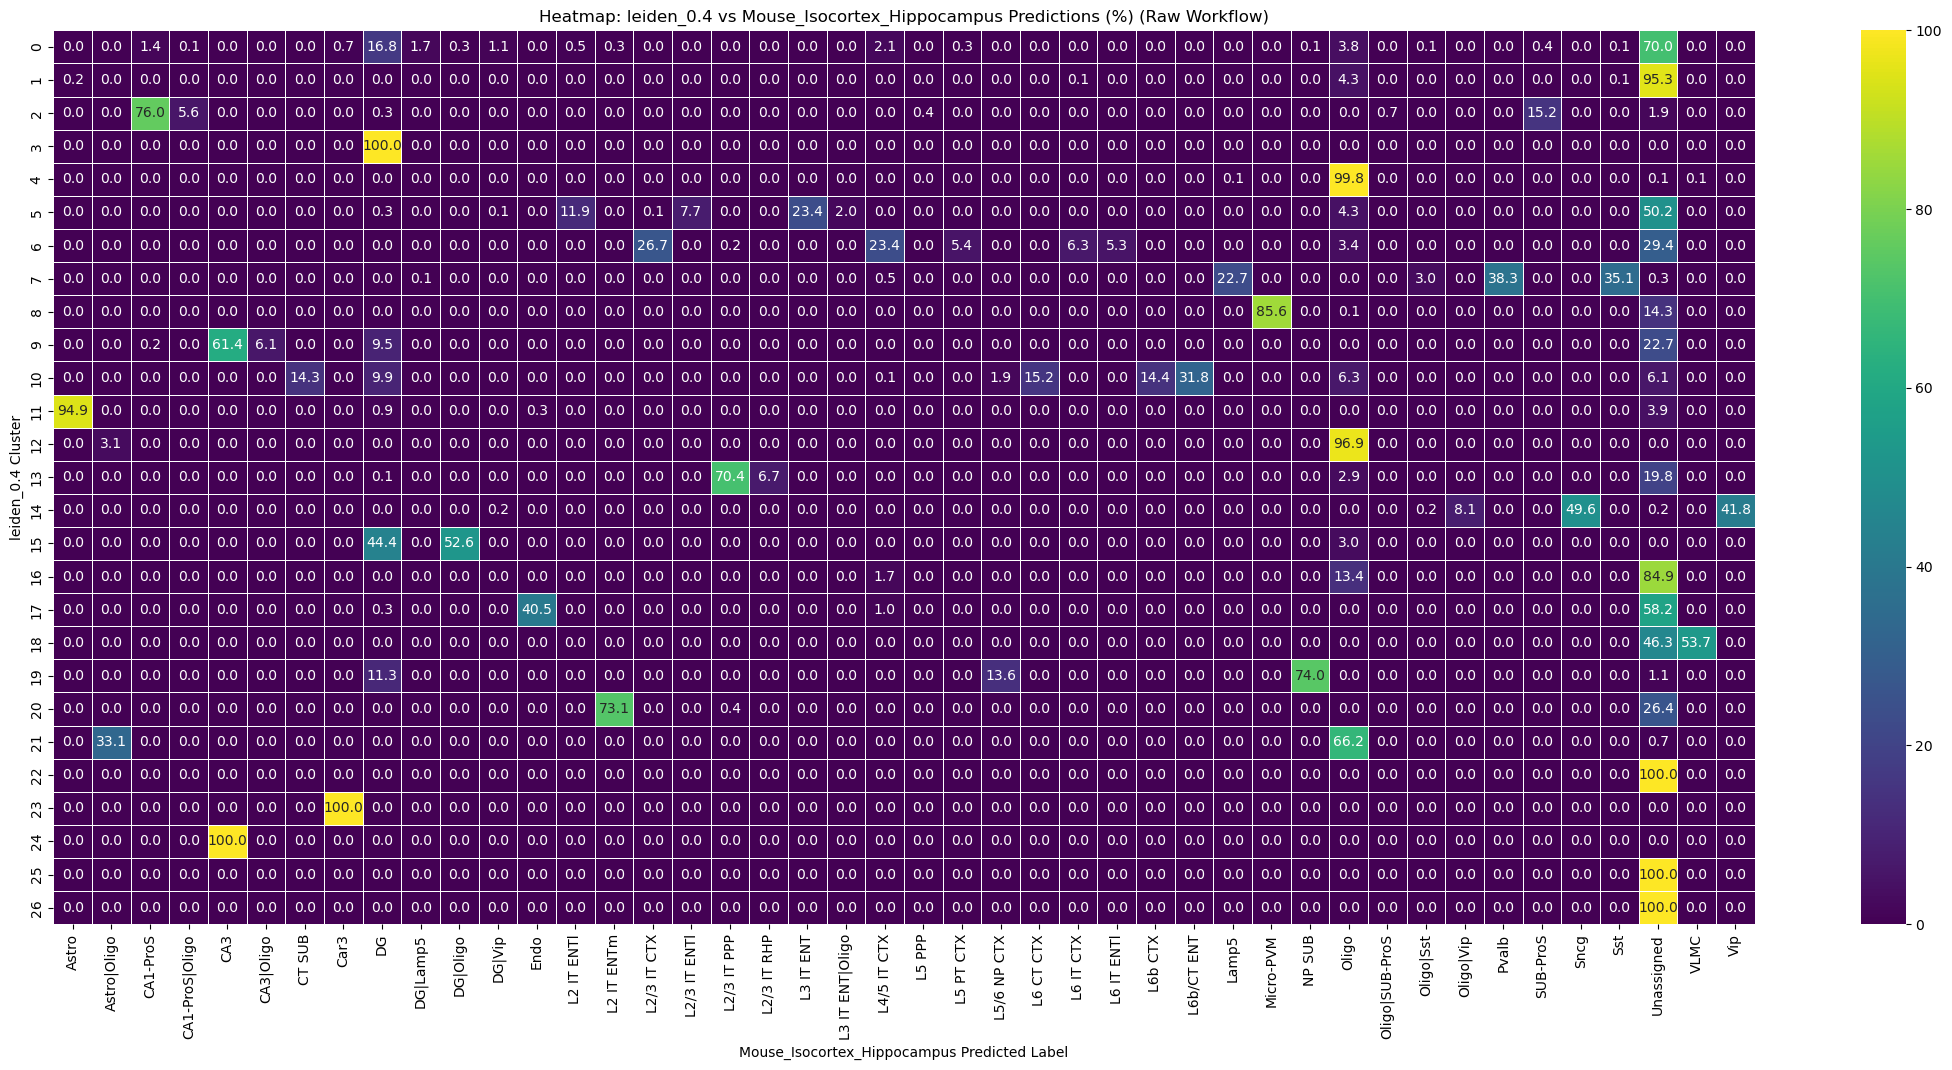

Generated Leiden comparison heatmap

--- Comparison for Mouse_Dentate_Gyrus vs leiden_0.4 --- 


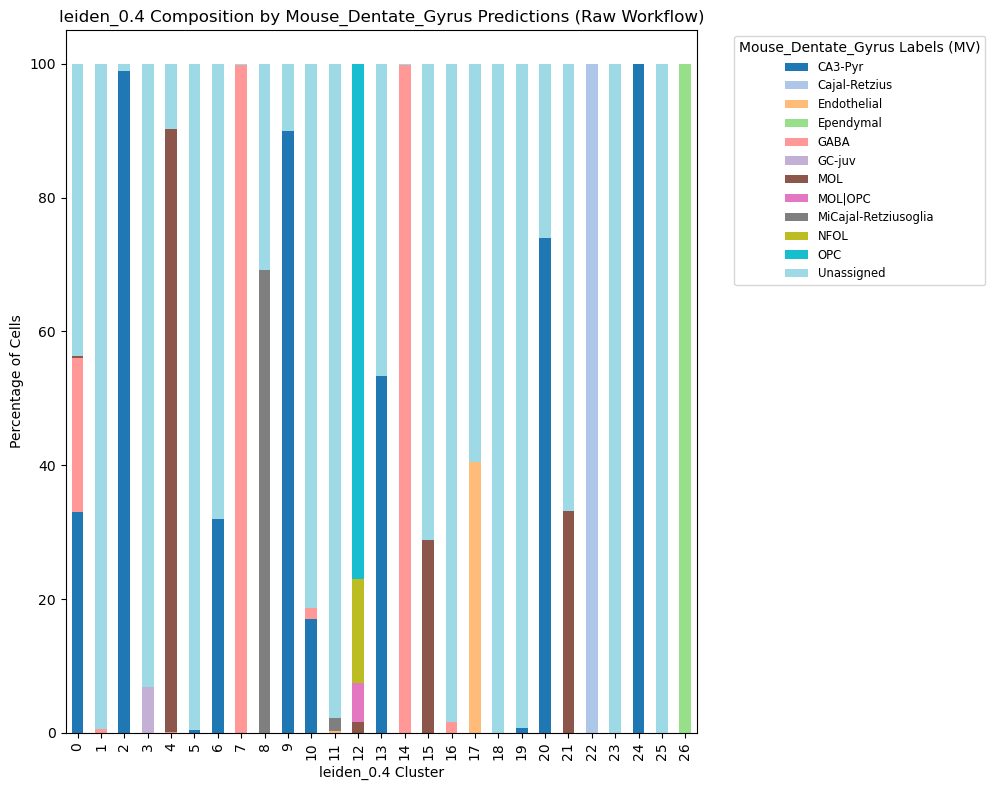

Generated stacked bar plot


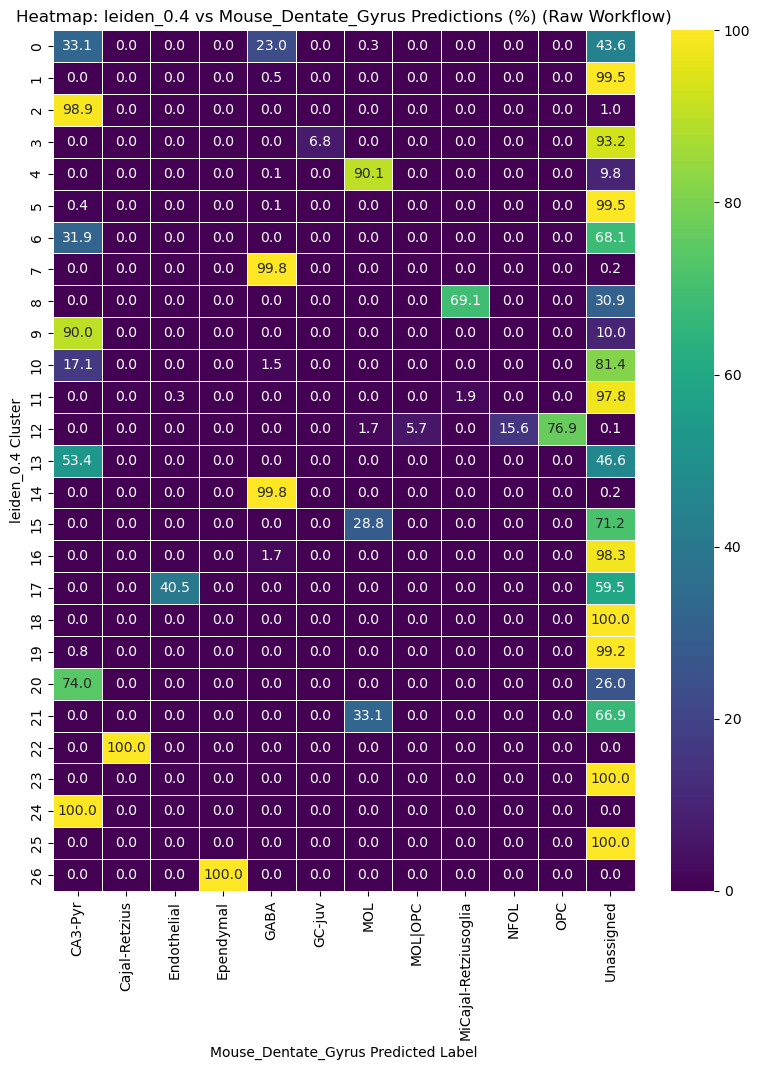

Generated Leiden comparison heatmap

Comparison analysis finished.


In [12]:
compare_annotations_with_leiden(adata_ct, LEIDEN_KEY, MODELS, OUTPUT_DIR, annotation_suffix='majority_voting') # noqa: F405

print("\nComparison analysis finished.")